In [14]:
import numpy as np
import awkward as ak
import uproot
from pylab import cm
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats
import time
import random
import src.functions as fn
import src.Network as net
import os

In [2]:
class Network:
    def __init__(self, vertices_indexes, vertices_x,vertices_y,vertices_z,vertices_E):
        self.ind = vertices_indexes
        self.x = vertices_x
        self.y = vertices_y
        self.z = vertices_z
        self.E = vertices_E
        self.wtMode=0
        self.weights=np.ones(len(vertices_indexes))
        
    def setWtMode(self,wtModeVal):
        self.wtMode=wtModeVal
        
    def edgeBuilderNew(self,nEdg=1):
        # Remove that exception for the moment. Not sure if needed.
        #if len(vertices_indexes) <= nEdg:
        #    raise ValueError("Number of attempted connections 'nEdg' cannot exceed the size of the graph")
        # Create matrix of indexes
        indexes = np.stack([ak.to_numpy(self.ind)]*len(self.ind),axis=0)
        # Perform energy filtering. Keep only nodes that have greater energy that the specified node
        enMtrx = np.stack([ak.to_numpy(self.E)]*len(self.E),axis=0)
        energyMask = enMtrx > np.transpose(enMtrx)
        # Calculate euclidean distance between all nodes and apply energy mask
        distMatr = self.euclideanMatrix()
        # Sort each row and keep the indexes of the sorted arrays
        distSort = np.argsort(distMatr,axis=1)
        # Sort the euclidean distance using the indexes from previous step
        energyMaskSorted = energyMask[np.arange(energyMask.shape[0])[:,None], distSort]
        indexesSorted = indexes[np.arange(energyMask.shape[0])[:,None], distSort]
        # Some awkward magic - converts innermost array length from const to var
        indexesSorted = ak.unflatten(ak.flatten(indexesSorted), ak.num(indexesSorted))
        energyMaskSorted = ak.unflatten(ak.flatten(energyMaskSorted), ak.num(energyMaskSorted))
        # Filter nodes that have lower energy and keep nEdg nearest neighbors
        indexesSorted = indexesSorted[energyMaskSorted]
        indexesSorted = indexesSorted[:,:nEdg]
        return ak.cartesian([self.ind, indexesSorted])

    def euclideanMatrix(self):
        ver_x = ak.to_numpy(self.x)
        ver_y = ak.to_numpy(self.y)
        ver_z = ak.to_numpy(self.z)
        #subtract.outer to compute difference in all combinations
        diff_x = np.subtract.outer(ver_x,ver_x)
        diff_y = np.subtract.outer(ver_y,ver_y)
        diff_z = np.subtract.outer(ver_z,ver_z)
        euclidean_matrix = np.sqrt(diff_x**2+diff_y**2+diff_z**2)

        return euclidean_matrix

    def calcWeight(self, id1, id2,n):
        E1 = self.E[id1]
        E2 = self.E[id2]
        dx = self.x[id2]-self.x[id1]
        dy = self.y[id2]-self.y[id1]
        dz = self.z[id2]-self.z[id1]
        dist = np.sqrt(np.power(dx,2)+np.power(dy,2)+np.power(dz,2))
        """
        Default is not weighted
        Method 1: max(E1, E2)
        Method 2: |E1 - E2|
        Method 3: (d)^(-n)
        Method 4: (method 1 or 2)*(method 3)
        """
        weight = 1;
        if(self.wtMode==1):
            weight = max(E1, E2)
        elif(self.wtMode==2):
            weight = np.abs(E1-E2)
        elif(self.wtMode==3):
            weight = np.power(dist,-n)
        elif(self.wtMode==4):
            weight = np.abs(E1-E2)*np.power(dist,-n)
        elif(self.wtMode==5):
            weight = E2
        return weight
    
    def calcWeights(self,nodes,edges,n):
        for edge in edges:
            #cluster1=layerCluster(edge[0])
            #cluster2=layerCluster(edge[1])
            
            #weight=1
            id1=np.where(nodes==edge.to_list()[0])
            id2=np.where(nodes==edge.to_list()[1])
            E1 = self.E[id1]
            E2 = self.E[id2]
            dx = self.x[id2]-self.x[id1]
            dy = self.y[id2]-self.y[id1]
            dz = self.z[id2]-self.z[id1]
            dist = np.sqrt(np.power(dx,2)+np.power(dy,2)+np.power(dz,2))
            """
            Default is not weighted
            Method 1: max(E1, E2)
            Method 2: |E1 - E2|
            Method 3: (d)^(-n)
            Method 4: (method 1 or 2)*(method 3)
            """
            weight = 1;
            if(self.wtMode==1):
                weight = max(E1, E2)
            elif(self.wtMode==2):
                weight = np.abs(E1-E2)
            elif(self.wtMode==3):
                weight = np.power(dist,-n)
            elif(self.wtMode==4):
                weight = np.abs(E1-E2)*np.power(dist,-n)
            elif(self.wtMode==5):
                weight = E2
            
            self.weights[id1]=weight

    def adjM(self,nodes,edges,isDirected=False):
        adj = np.zeros((len(nodes),len(nodes)))
        for edge in edges:
            #cluster1=layerCluster(edge[0])
            #cluster2=layerCluster(edge[1])
            
            #weight=1
            idx0=np.where(nodes==edge.to_list()[0])
            idx1=np.where(nodes==edge.to_list()[1])
            weight=self.calcWeight(idx0,idx1,1)
            adj[idx0,idx1] = weight
            self.weights[idx0]=weight
            if(not isDirected):
                adj[idx1,idx0] = weight
        maxVal=adj.max()
        return adj/maxVal

    def centralityEigen(self,nodes,edges,isDirected=False,printStuff=False):
        adj=self.adjM(nodes,edges,isDirected)
        rows,columns= adj.shape
        eigvals,vecr= np.linalg.eig(adj)
        i=np.argmax(np.abs(eigvals)) 
        c_eig= vecr[:,i]
        if(c_eig[0]<0):
            c_eig *=-1
        if(printStuff):
            print(eigvals)
            print(vecr)
        c_eig_real=c_eig.real
        norm=sum(c_eig_real)
        return c_eig_real/norm

    def centralityKatz(self,nodes,edges,isDirected=False,printStuff=False):
        adj=self.adjM(nodes,edges,isDirected)
        rows,columns= adj.shape
        Id=np.identity(rows)
        eigvals,vecr= np.linalg.eig(adj)
        i=np.argmax(np.abs(eigvals)) 
        alpha= 0.9/eigvals[i]
        c_katz=(np.linalg.inv(Id-alpha*adj.T)-Id)@np.ones((rows)).T
        if(printStuff):
            print(eigvals)
            print(vecr)
        c_katz_real=c_katz.real
        norm=sum(c_katz_real)
        return c_katz_real/norm

    def centralityPageRank(self,nodes,edges,df,isDirected=False,printStuff=False):
        adj=self.adjM(nodes,edges,isDirected)
        rows,columns= adj.shape
        m_ones=np.ones((rows,columns))
        m_pr=df*adj+(1-df)*m_ones/rows
        eigvals,vecr= np.linalg.eig(m_pr)
        i=np.argmax(np.abs(eigvals)) 
        c_pr= vecr[:,i]
        if(c_pr[0]<0):
            c_pr *=-1
        if(printStuff):
            print(eigvals)
            print(vecr)
        c_pr_real=c_pr.real
        norm=sum(c_pr_real)
        return c_pr_real/norm

    def nXCentralityEigen(self,nodes,edges,isDirected=False):
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        edges=edges.to_list()
        edgesWeights=[(edges[i][0],edges[i][1],self.weights[i]) for i in range(len(edges))]
        #print(edgesWeights)
        G.add_weighted_edges_from(edgesWeights)
        #G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes),weights=self.weights)
        centr_d = nx.eigenvector_centrality_numpy(G,weight='weight')
        centr_np = np.array(list(centr_d.items()))
        return centr_np[centr_np[:, 0].argsort()][:,1]

    def nXCentralityKatz(self,nodes,edges,isDirected=False):
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        edges=edges.to_list()
        edgesWeights=[(edges[i][0],edges[i][1],self.weights[i]) for i in range(len(edges))]
        #print(edgesWeights)
        G.add_weighted_edges_from(edgesWeights)
        #G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes),weights=self.weights)
        centr_d = nx.katz_centrality_numpy(G,weight='weight')
        centr_np = np.array(list(centr_d.items()))
        return centr_np[centr_np[:, 0].argsort()][:,1]
    
    def nXCentralityPageRank(self,nodes,edges,isDirected=False):
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        edges=edges.to_list()
        edgesWeights=[(edges[i][0],edges[i][1],self.weights[i]) for i in range(len(edges))]
        #print(edgesWeights)
        G.add_weighted_edges_from(edgesWeights)
        #G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes))
        centr_d = nx.pagerank_numpy(G,weight='weight')
        centr_np = np.array(list(centr_d.items()))
        return centr_np[centr_np[:, 0].argsort()][:,1]
    
    
    def longestPathSource(self,nodes,edges,centralities,isDirected=False):
        """
        Finds the longest path in the network from the max
        of the stortest path algorithm.
        """
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        edges=edges.to_list()
        edgesWeights=[(edges[i][0],edges[i][1],self.weights[i]) for i in range(len(edges))]
        #print(edgesWeights)
        G.add_weighted_edges_from(edgesWeights)
        #G.add_edges_from(ak.to_numpy(edges),weights=self.weights)
        G.add_nodes_from(ak.to_numpy(nodes),weights=self.weights)

        #Highest centrality node
        i_centralityMax=np.argmax(centralities)
        source=nodes[i_centralityMax]
        #Finds the shortest path from the highest centrality to all other nodes
        pathList=nx.shortest_path_length(G,source=source,weight="weight")
        #Takes the max of all paths to find the longest path
        longestShortestPath=max(pathList.values())
        return longestShortestPath

    def longestPathInitialNode(self,nodes,edges,isDirected=False):
        """
        Finds the longest path in the network from the max
        of the stortest path algorithm.
        """
        if(isDirected):
            G=nx.DiGraph()
        else:
            G=nx.Graph()
        edges=edges.to_list()
        edgesWeights=[(edges[i][0],edges[i][1],self.weights[i]) for i in range(len(edges))]
        #print(edgesWeights)
        G.add_weighted_edges_from(edgesWeights)
        G.add_nodes_from(ak.to_numpy(nodes))
        #print(G.edges.data("weights"))
        #print(G.edges(data=True))
        source=nodes[0]
        #Finds the shortest path from the first node to all other nodes
        pathList=nx.shortest_path_length(G,source=source,weight="weight")
        #Takes the max of all paths to find the longest path
        longestShortestPath=max(pathList.values())
        return longestShortestPath

    def plotTrackster(self,fig, ax, x, y, z, heatmap=None, indexes=None, edges=None, label='Vertex Energy (GeV)'):
        ax.set_xlabel('X (cm)')
        ax.set_ylabel('Y (cm)')
        ax.set_zlabel('Z (cm)')
        colmap = cm.ScalarMappable(cmap=cm.viridis)
        if len(heatmap) > 0 :
            colmap.set_array(heatmap)
            yg = ax.scatter(x, y, z, c=cm.viridis(heatmap/max(heatmap)), marker='o', linewidth=2)
            cb = fig.colorbar(colmap,label=label)
        else:
            yg =ax.scatter(x, y, z, marker='o') 
        edges=ak.to_numpy(edges)
        if len(heatmap) > 0:
            for ind in edges:
                if len(ind) == 0:
                    continue
                for ied in ind:
                    idx0 = ak.where(indexes == ied.to_list()[0])[0][0]
                    idx1 = ak.where(indexes == ied.to_list()[1])[0][0]
                    ax.plot(
                        [x[idx0] ,x[idx1]],
                        [y[idx0] ,y[idx1]],
                        [z[idx0] ,z[idx1]],
                        'black'
                    )
        plt.show()


    def incompleteTracksters(self,vertices_layer,seed1=None,seed2=None):
        v_layer=ak.to_numpy(vertices_layer)
        n=len(vertices_layer)
        #print(n)
        if(seed1!=None):
            np.random.seed(seed1)
        q1=np.random.normal(0.18,0.02)
        if(seed2!=None):
            np.random.seed(seed2)
        q2=np.random.normal(0.18,0.02)
        return slice(int(n*q1),int(n*(1-q2)))

    def ld(self):
        if(self.z[0]<0):
            offset=320
        else:
            offset=-320

        ldVal=sum((self.z+offset)*self.E)
        return ldVal

    def delta_RT(self,Eweighted=False):
        argmax_E=ak.argmax(self.E)

        vEmax_x=self.x[argmax_E]
        vEmax_y=self.y[argmax_E]
        RvEmax=np.sqrt(vEmax_x**2+vEmax_y**2)

        R=np.sqrt(self.x**2+self.y**2)

        if(Eweighted):
            delta_R=sum((R-RvEmax)**2*self.E/self.E[argmax_E])
        else:
            delta_R=sum((R-RvEmax)**2)

        return delta_R

    def delta_R(self,Eweighted=False):
        argmax_E=ak.argmax(self.E)

        vEmax_x=self.x[argmax_E]
        vEmax_y=self.y[argmax_E]
        vEmax_z=self.z[argmax_E]
        RvEmax=np.sqrt(vEmax_x**2+vEmax_y**2+vEmax_z**2)

        R=np.sqrt(self.x**2+self.y**2+self.z**2)

        delta_R=sum((R-RvEmax)**2)

        return delta_R

    def delta_RT_std(self,Eweighted=False):
        argmax_E=ak.argmax(self.E)

        vEmax_x=self.x[argmax_E]
        vEmax_y=self.y[argmax_E]
        RvEmax=np.sqrt(vEmax_x**2+vEmax_y**2)

        R=np.sqrt((self.x-vEmax_x)**2+(selfy-vEmax_y)**2)

        delta_R_std=np.sqrt(np.abs(sum(R**2)-sum(R)**2))

        return delta_R_std

    def maxE_z(self):
        argmax_E=ak.argmax(self.E)
        if(self.z[0]<0):
            maxE_z=-1*(self.z[argmax_E]+320)
        else:
            maxE_z=(self.z[argmax_E]-320)
        return maxE_z

    def sd(self):
        ldVal=self.ld()
        E_tot=ak.sum(self.E)
        return ldVal/E_tot

    def maxAbsZ(self):
        if(self.z[0]<0):
            maxZ=ak.min(self.z)
        else:
            maxZ=ak.max(self.z)
        return abs(maxZ)




In [3]:
#%matplotlib inline

import mplhep as hep

# Make plots look more HEP-like
plt.style.use(hep.style.ROOT)

In [24]:
#filenameBase="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta3_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225846/0000/"

#filename="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta3_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225846/0000/hgcalNtuple_*.root:ana/tracksters"
filenameFull100GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225928/0000/ntuples.root"
filenameFull50GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E50Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225808/0000/ntuples.root"
filenameFull25GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E25Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225704/0000/ntuples.root"
folder="CloseByDoubleGamma_E50IncVsE25Com_Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_Weights"
savefigs=True
#file = uproot.open(filename)
#fileFull=uproot.concatenate(filename)
file=uproot.open(filenameFull50GeV)
file50=uproot.open(filenameFull25GeV)
datasetName="50 GeV to inc vs 25 GeV com"

In [25]:
tracksters=file["ana/tracksters"]
clusters=file["ana/clusters"]
vertices_indexes = tracksters['vertices_indexes'].array()
vertices_x = tracksters['vertices_x'].array()
vertices_y = tracksters['vertices_y'].array()
vertices_z = tracksters['vertices_z'].array()
vertices_E = tracksters['vertices_energy'].array()
vertices_layers = tracksters['vertices_layer'].array()

tracksters_50=file50["ana/tracksters"]
vertices_E_50 = tracksters_50['vertices_energy'].array()
vertices_indexes_50 = tracksters_50['vertices_indexes'].array()
vertices_x_50 = tracksters_50['vertices_x'].array()
vertices_y_50 = tracksters_50['vertices_y'].array()
vertices_z_50 = tracksters_50['vertices_z'].array()
vertices_layers_50=tracksters_50['vertices_layer'].array()
#trackster_E_50=tracksters_50['raw_energy'].array()


In [81]:
evt=1
tr=1
TrNet=net.Network(vertices_indexes[evt,tr],vertices_x[evt,tr],vertices_y[evt,tr],
                         vertices_z[evt,tr],vertices_E[evt,tr])

In [82]:
edges_1 = TrNet.edgeBuilderNew()
edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
c_pr_dir=TrNet.centralityPageRank(vertices_indexes[evt,tr],edges_1,0.85,True)
c_pr_undir=TrNet.centralityPageRank(vertices_indexes[evt,tr],edges_1,0.85,False)
TrNet.longestPathSource(vertices_indexes[evt,tr],edges_1,c_pr_dir,True)
TrNet.longestPathSource(vertices_indexes[evt,tr],edges_1,c_pr_undir)
TrNet.nXCentralityEigen(vertices_indexes[evt,tr],edges_1,False)

array([0.02423145, 0.05260564, 0.0899736 , 0.14272396, 0.21987522,
       0.3346176 , 0.15413306, 0.35243504, 0.16234022, 0.26816658,
       0.2297454 , 0.23060281, 0.27088538, 0.16466408, 0.35748007,
       0.34052751, 0.15685532, 0.22493816, 0.14780552, 0.09594255,
       0.06048246, 0.03536281, 0.01628897])

In [8]:

print(TrNet.nXCentralityKatz(vertices_indexes[evt,tr],edges_1,True))
print(TrNet.nXCentralityKatz(vertices_indexes[evt,tr],edges_1,False))
print(TrNet.nXCentralityEigen(vertices_indexes[evt,tr],edges_1,True))
print(TrNet.nXCentralityEigen(vertices_indexes[evt,tr],edges_1,False))
print(TrNet.centralityKatz(vertices_indexes[evt,tr],edges_1))
#print(fn.centralityKatz(vertices_indexes[n],edges[n],True))
print(TrNet.centralityEigen(vertices_indexes[evt,tr],edges_1,True))
print(TrNet.centralityEigen(vertices_indexes[evt,tr],edges_1,False))
print(TrNet.centralityPageRank(vertices_indexes[evt,tr],edges_1,0.85,True))
print(TrNet.centralityPageRank(vertices_indexes[evt,tr],edges_1,0.85))
print(TrNet.nXCentralityPageRank(vertices_indexes[evt,tr],edges_1,True))
print(TrNet.nXCentralityPageRank(vertices_indexes[evt,tr],edges_1))

[0.18823897 0.20706287 0.20894526 0.2091335  0.20915232 0.2279781
 0.18823897 0.25077633 0.18823897 0.20915648 0.20917512 0.20936147
 0.21122504 0.18823897 0.2298607  0.22797829 0.18823897 0.2091542
 0.20915232 0.2091335  0.20894526 0.20706287 0.18823897]
[0.18809105 0.20709408 0.20903341 0.20942365 0.21138676 0.23062755
 0.19044439 0.23062795 0.19044443 0.21139119 0.20946755 0.20946795
 0.21139559 0.1904488  0.23067159 0.23105509 0.19048715 0.21143191
 0.2094476  0.20922776 0.20901362 0.20709208 0.18809085]
[-5.55111512e-17 -6.66133815e-16 -1.66394676e-14 -2.98414071e-13
 -4.75169903e-12 -5.62259683e-11 -8.32667268e-17  9.99065486e-01
 -8.32667268e-17  4.31869046e-02  1.74390981e-03  6.47567919e-05
  2.12536388e-06 -2.16840434e-19  5.47812830e-08  5.03491138e-10
 -1.38777878e-16 -6.55566296e-11 -6.66944278e-12 -4.46059856e-13
 -2.54518628e-14 -1.33226763e-15 -1.11022302e-16]
[0.02423145 0.05260564 0.0899736  0.14272396 0.21987522 0.3346176
 0.15413306 0.35243504 0.16234022 0.26816658 

In [26]:


N_evt = len(vertices_indexes_50)
#N_tr=100
modes=[0,2,3]

comShowerShapes=[]
incShowerShapes=[]

longestComPaths=np.zeros((N_evt*2,len(modes),2))
#print(longestComPaths
longestComPathsFirstNode=np.zeros((N_evt*2,len(modes),2))
comCenParams=np.zeros((N_evt*2,len(modes),4))




for evt in range(N_evt):
    for tr in range(min(len(vertices_indexes_50[evt]),2)):
        for j in range(len(modes)):
            TrNet=Network(vertices_indexes_50[evt,tr],vertices_x_50[evt,tr],vertices_y_50[evt,tr],
                             vertices_z_50[evt,tr],vertices_E_50[evt,tr])

            TrNet.setWtMode(modes[j])

            #v_layers=vertices_layers[evt][tr]
            v_ind=vertices_indexes_50[evt][tr]
            #v_x=vertices_x[evt][tr]
            #v_y=vertices_y[evt][tr]
            #v_z=vertices_z[evt][tr]
            #v_E=vertices_E[evt][tr] 


            edges_1 = TrNet.edgeBuilderNew()
            edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
            TrNet.calcWeights(v_ind,edges_1,2)

            c_nxpr_dir=TrNet.nXCentralityPageRank(v_ind,edges_1,True)
            c_nxpr_undir=TrNet.nXCentralityPageRank(v_ind,edges_1,False)
            #c_nxeig_undir=TrNet.nXCentralityEigen(v_ind,edges_1,False)
            #c_pr_dir=TrNet.centralityPageRank(v_ind,edges_1,0.85,True)
            #c_pr_undir=TrNet.centralityPageRank(v_ind,edges_1,0.85,False)
            #print(evt,tr,mode,0)
            #print(c_nxpr_dir)
            #print(longestPath)
            longestComPaths[2*evt+tr,j,0]=TrNet.longestPathSource(v_ind,edges_1,c_nxpr_dir,True)
            longestComPaths[2*evt+tr,j,1]=TrNet.longestPathSource(v_ind,edges_1,c_nxpr_undir)

            longestComPathsFirstNode[2*evt+tr,j,0]=TrNet.longestPathInitialNode(v_ind,edges_1,True)
            longestComPathsFirstNode[2*evt+tr,j,1]=TrNet.longestPathInitialNode(v_ind,edges_1)
            #print(c_nxpr_dir)
            #print(c_nxpr_undir)
            #print(c_nxeig_undir)
            centrality=c_nxpr_undir
            comCenParams[2*evt+tr,j,0]=np.mean(centrality)
            comCenParams[2*evt+tr,j,1]=np.std(centrality)
            comCenParams[2*evt+tr,j,2]=scipy.stats.skew(centrality)
            comCenParams[2*evt+tr,j,3]=scipy.stats.kurtosis(centrality)

N_evt=len(vertices_indexes)

longestInComPaths=np.zeros((N_evt*2,len(modes),2))
longestInComPathsFirstNode=np.zeros((N_evt*2,len(modes),2))
incCenParams=np.zeros((N_evt*2,len(modes),4))

for evt in range(N_evt):
    for tr in range(min(len(vertices_indexes[evt]),2)):
        for j in range(len(modes)):
            incSlice=fn.incompleteTracksters(vertices_layers[evt,tr],0.23,0.2)
            #print(incSlice)
            v_ind_inc=vertices_indexes[evt,tr][incSlice]
            v_x_inc=vertices_x[evt,tr][incSlice]
            v_y_inc=vertices_y[evt,tr][incSlice]
            v_z_inc=vertices_z[evt,tr][incSlice]
            v_E_inc=vertices_E[evt,tr][incSlice]
            if(len(v_ind_inc)<2):
                continue
            TrNet=Network(v_ind_inc, v_x_inc, v_y_inc,v_z_inc,v_E_inc)

            TrNet.setWtMode(modes[j])

            edges_1 = TrNet.edgeBuilderNew()
            edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
            TrNet.calcWeights(v_ind_inc,edges_1,2)

            c_nxpr_dir=TrNet.nXCentralityPageRank(v_ind_inc,edges_1,True)
            c_nxpr_undir=TrNet.nXCentralityPageRank(v_ind_inc,edges_1,False)
            #c_nxeig_undir=TrNet.nXCentralityEigen(v_ind,edges_1,False)
            #c_pr_dir=TrNet.centralityPageRank(v_ind,edges_1,0.85,True)
            #c_pr_undir=TrNet.centralityPageRank(v_ind,edges_1,0.85,False)
            #print(evt,tr,mode,0)
            #print(c_nxpr_dir)
            #print(longestPath)
            longestInComPaths[2*evt+tr,j,0]=TrNet.longestPathSource(v_ind_inc,edges_1,c_nxpr_dir,True)
            longestInComPaths[2*evt+tr,j,1]=TrNet.longestPathSource(v_ind_inc,edges_1,c_nxpr_undir)

            longestInComPathsFirstNode[2*evt+tr,j,0]=TrNet.longestPathInitialNode(v_ind_inc,edges_1,True)
            longestInComPathsFirstNode[2*evt+tr,j,1]=TrNet.longestPathInitialNode(v_ind_inc,edges_1)
            #print(c_nxpr_dir)
            #print(c_nxpr_undir)
            #print(c_nxeig_undir)
            centrality=c_nxpr_undir
            incCenParams[2*evt+tr,j,0]=np.mean(centrality)
            incCenParams[2*evt+tr,j,1]=np.std(centrality)
            incCenParams[2*evt+tr,j,2]=scipy.stats.skew(centrality)
            incCenParams[2*evt+tr,j,3]=scipy.stats.kurtosis(centrality)



In [21]:
print(longestInComPaths[:20,0])

[[ 0. 10.]
 [ 0. 12.]
 [ 0.  9.]
 [ 0.  5.]
 [ 0.  6.]
 [ 0.  5.]
 [ 0.  0.]
 [ 1.  8.]
 [ 0.  6.]
 [ 0.  5.]
 [ 0. 10.]
 [ 0. 10.]
 [ 0.  3.]
 [ 0.  0.]
 [ 0.  7.]
 [ 0. 10.]
 [ 0. 10.]
 [ 0. 15.]
 [ 0. 11.]
 [ 0.  9.]]


In [7]:
comShowerShapes=np.asarray(comShowerShapes)
incShowerShapes=np.asarray(incShowerShapes)
#longestComPaths=np.asarray(longestComPaths)
longestInComPaths=np.asarray(longestInComPaths)
longestComPathsFirstNode=np.asarray(longestComPathsFirstNode)
longestInComPathsFirstNode=np.asarray(longestInComPathsFirstNode)
comCenParams=np.asarray(comCenParams)
incCenParams=np.asarray(incCenParams)

In [60]:
def plotcomvsinc(complete,incomplete,xlabels,saveFileNames=None,bins=50):
    %matplotlib inline
    for i in range(len(complete[0])):
        plt.figure(figsize=(8,6))
        plt.hist(complete[:,i,1], histtype="step",bins=bins, color='b',label='Complete')
        plt.hist(incomplete[:,i,1], histtype="step",bins=bins, color='r',label='Incomplete')
        plt.legend()
        plt.ylabel("N",fontsize=20)
        plt.xlabel(xlabels,fontsize=20)
        plt.title(datasetName,fontsize=20)
        #plt.xlim(min(completeShowerShapes[:,i]-5),max(completeShowerShapes[:,i]+5))
        if(savefigs):
            plt.savefig("figures/"+folder+"/"+saveFileNames[i]+".png")
        plt.show()

In [27]:
initString="Longest path from highest centrality"
if not os.path.isdir("figures/"+folder):
    os.makedirs("figures/"+folder)
    
#newList=[("incVsCom_"+i.replace(" ","_")) for i in xlabels2]
#xlabelsPaths=["Weight=1","Weight=max(E1,E2)","Weight=abs(E2-E1)","maxium Z position[cm]","delta_R std[cm]"]
#plotcomvsinc(longestComPaths,longestInComPaths,initString,bins=20)

15.0


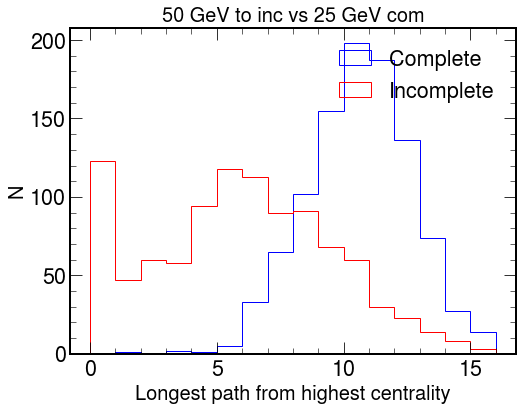

In [28]:
print((max(longestComPaths[:,0,1])-min(longestComPaths[:,0,1])))
plt.figure(figsize=(8,6))
plt.hist(longestComPaths[:,0,1], histtype="step",bins=int(max(longestComPaths[:,0,1])-min(longestComPaths[:,0,1])), color='b',label='Complete')
plt.hist(longestInComPaths[:,0,1], histtype="step",bins=int(max(longestInComPaths[:,0,1])-min(longestInComPaths[:,0,1])), color='r',label='Incomplete')
plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel(initString,fontsize=20)
plt.title(datasetName,fontsize=20)
#plt.xlim(min(completeShowerShapes[:,i]-5),max(completeShowerShapes[:,i]+5))
#if(savefigs):
    #plt.savefig("figures/"+folder+"/"+saveFileNames[i]+".png")
plt.show()

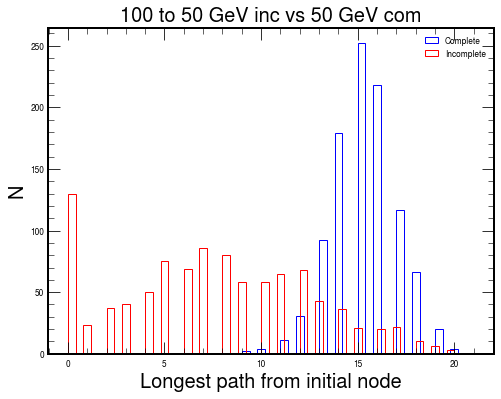

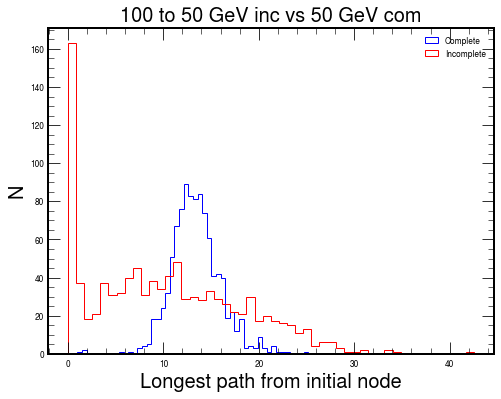

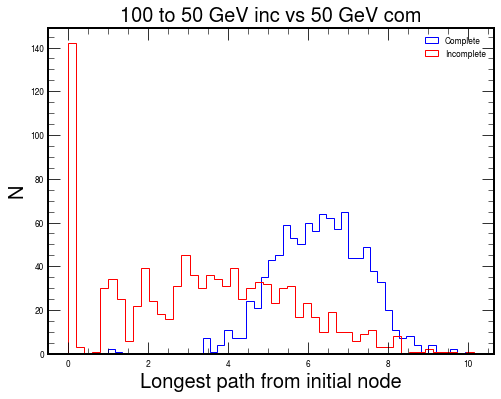

In [70]:
initString="Longest path from initial node"
#labelsPaths=["Weight=1","Weight=max(E1,E2)","Weight=abs(E2-E1)",,"maxium Z position[cm]","delta_R std[cm]"]
plotcomvsinc(longestComPathsFirstNode,longestInComPathsFirstNode,initString)

IndexError: index 3 is out of bounds for axis 1 with size 3

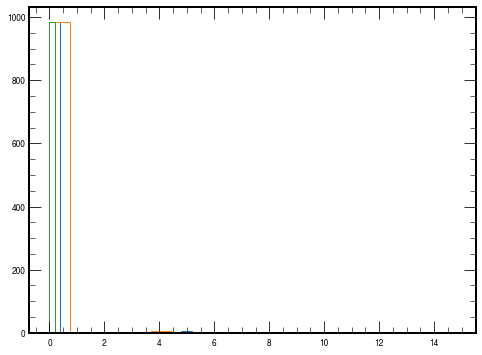

In [71]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(longestComPaths[:,0,0], bins=20, histtype="step",label='1')
plt.hist(longestComPaths[:,1,0], bins=20, histtype="step",label='max(E1,E2)')
plt.hist(longestComPaths[:,2,0], bins=20, histtype="step",label='abs(E2-E1)')
plt.hist(longestComPaths[:,3,0], bins=20, histtype="step",label='power(dist,-1)')
plt.hist(longestComPaths[:,4,0], bins=20, histtype="step",label='abs(E2-E1)power(dist,-1)')
plt.hist(longestComPaths[:,5,0], bins=20, histtype="step",label='E2')

plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Longest path in the network",fontsize=20)
plt.title(datasetName+" PageRank Directed centrality",fontsize=20)
plt.show()

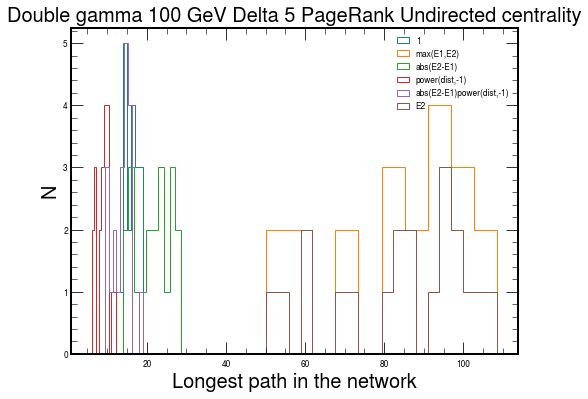

In [148]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(longestComPaths[:,0,1], bins=int(max(longestComPaths[:,0,1])-min(longestComPaths[:,0,1])), histtype="step",label='1')
plt.hist(longestComPaths[:,1,1], bins=10, histtype="step",label='max(E1,E2)')
plt.hist(longestComPaths[:,2,1], bins=10, histtype="step",label='abs(E2-E1)')
plt.hist(longestComPaths[:,3,1], bins=10, histtype="step",label='power(dist,-1)')
plt.hist(longestComPaths[:,4,1], bins=10, histtype="step",label='abs(E2-E1)power(dist,-1)')
plt.hist(longestComPaths[:,5,1], bins=20, histtype="step",label='E2')

plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Longest path in the network",fontsize=20)
plt.title(datasetName+" PageRank Undirected centrality",fontsize=20)
plt.show()

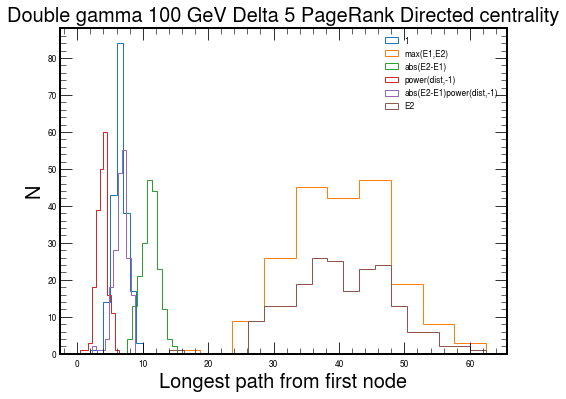

In [12]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(longestComPathsFirstNode[:,0,0], bins=int(max(longestComPathsFirstNode[:,0,0])-min(longestComPathsFirstNode[:,0,0])), histtype="step",label='1')
plt.hist(longestComPathsFirstNode[:,1,0], bins=10, histtype="step",label='max(E1,E2)')
plt.hist(longestComPathsFirstNode[:,2,0], bins=10, histtype="step",label='abs(E2-E1)')
plt.hist(longestComPathsFirstNode[:,3,0], bins=10, histtype="step",label='power(dist,-1)')
plt.hist(longestComPathsFirstNode[:,4,0], bins=10, histtype="step",label='abs(E2-E1)power(dist,-1)')
plt.hist(longestComPathsFirstNode[:,5,0], bins=20, histtype="step",label='E2')

plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Longest path from first node",fontsize=20)
plt.title(datasetName+" PageRank Directed centrality",fontsize=20)
plt.show()

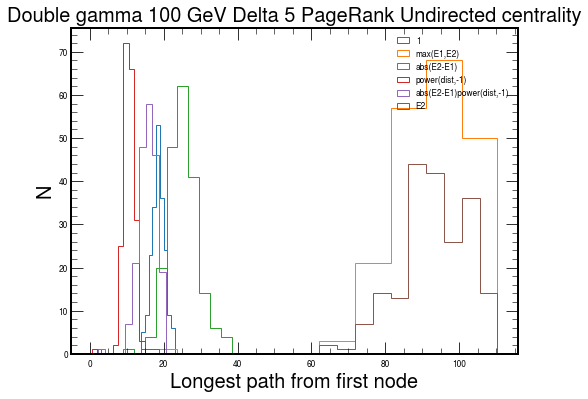

In [13]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(longestComPathsFirstNode[:,0,1], bins=int(max(longestComPathsFirstNode[:,0,1])-min(longestComPathsFirstNode[:,0,1])), histtype="step",label='1')
plt.hist(longestComPathsFirstNode[:,1,1], bins=10, histtype="step",label='max(E1,E2)')
plt.hist(longestComPathsFirstNode[:,2,1], bins=10, histtype="step",label='abs(E2-E1)')
plt.hist(longestComPathsFirstNode[:,3,1], bins=10, histtype="step",label='power(dist,-1)')
plt.hist(longestComPathsFirstNode[:,4,1], bins=10, histtype="step",label='abs(E2-E1)power(dist,-1)')
plt.hist(longestComPathsFirstNode[:,5,1], bins=20, histtype="step",label='E2')

plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Longest path from first node",fontsize=20)
plt.title(datasetName+" PageRank Undirected centrality",fontsize=20)
plt.show()

In [14]:
comCenParams

array([[[ 0.05555556,  0.012284  ,  0.59319711,  2.44360132],
        [ 0.05555556,  0.01864535, -0.42497782, -0.30664401],
        [ 0.05555556,  0.02047173, -0.27449774, -1.16553266],
        [ 0.05555556,  0.01490022, -0.71172285,  1.71779348],
        [ 0.05555556,  0.02173007, -0.58015275, -0.76539739],
        [ 0.05555556,  0.01864535, -0.42497782, -0.30664401]],

       [[ 0.04      ,  0.01337876,  0.79748753,  0.78570622],
        [ 0.04      ,  0.02165384, -0.05571243, -1.30678479],
        [ 0.04      ,  0.02343839,  0.81095819,  0.58322085],
        [ 0.04      ,  0.01630117,  0.80886842,  0.79370827],
        [ 0.04      ,  0.02478103,  0.76698782,  0.08598109],
        [ 0.04      ,  0.02165384, -0.05571243, -1.30678479]],

       [[ 0.03846154,  0.01426332,  1.80239808,  5.01822207],
        [ 0.03846154,  0.01774232,  0.55210342,  0.45457222],
        [ 0.03846154,  0.01436569,  0.08800393, -0.18906627],
        [ 0.03846154,  0.01613927,  1.47748032,  3.89917788],
    

In [72]:
def plotComVsIncCenParams(complete,incomplete,xlabels,saveFileNames=None,bins=20):
    %matplotlib inline
    for i in range(len(complete[0])):
        for j in range(4):
            plt.figure(figsize=(8,6))
            plt.hist(complete[:,i,j], histtype="step",bins=bins[0][j], color='b',label='Complete')
            plt.hist(incomplete[:,i,j], histtype="step",bins=bins[1][j], color='r',label='Incomplete')
            plt.legend()
            plt.ylabel("N",fontsize=20)
            plt.xlabel(xlabels[j],fontsize=20)
            plt.title(datasetName,fontsize=20)
            #plt.xlim(min(completeShowerShapes[:,i]-5),max(completeShowerShapes[:,i]+5))
            #if(savefigs):
            #    plt.savefig("figures/"+folder+"/"+saveFileNames[i]+".png")
            plt.show()
        
        

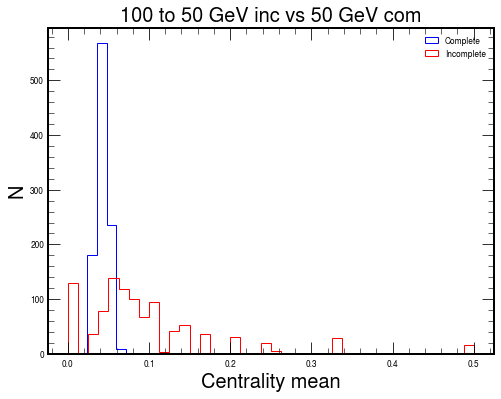

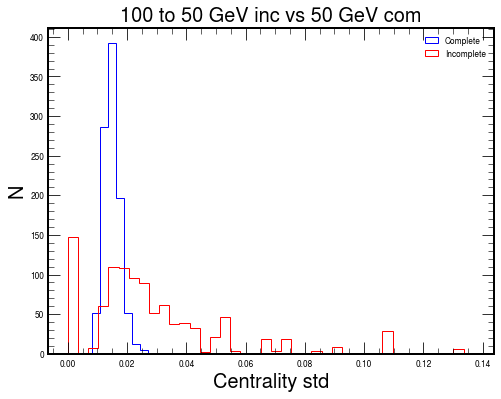

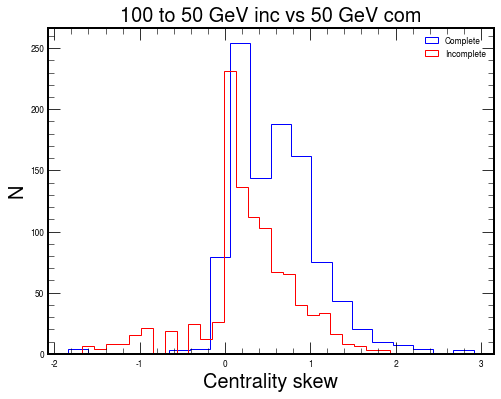

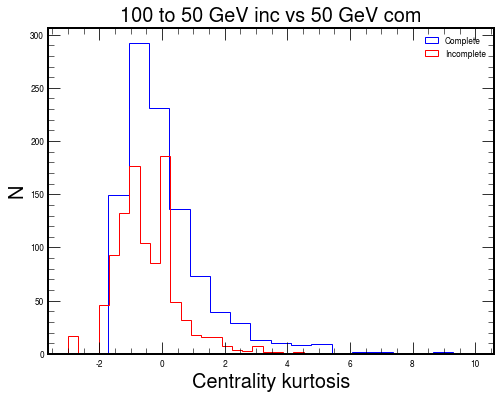

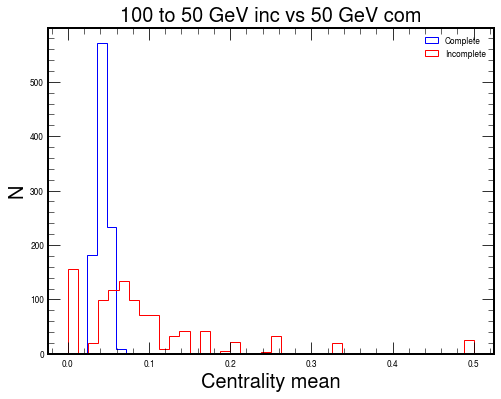

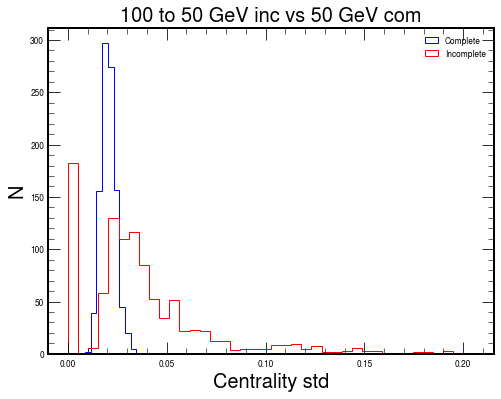

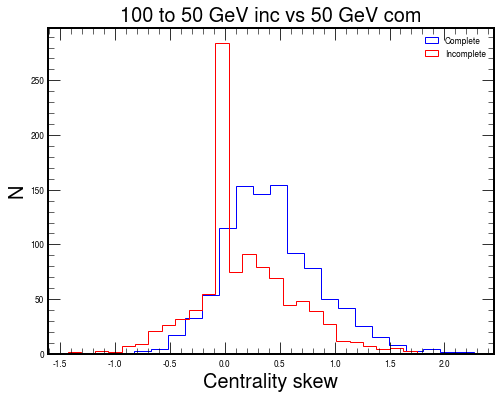

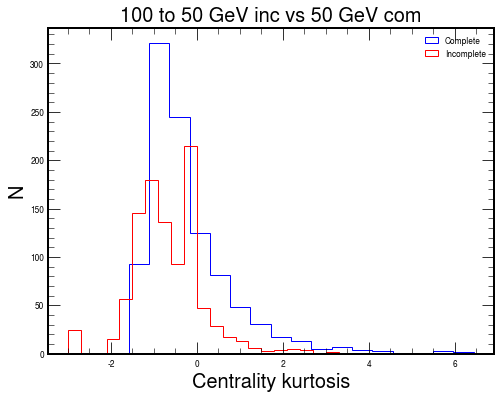

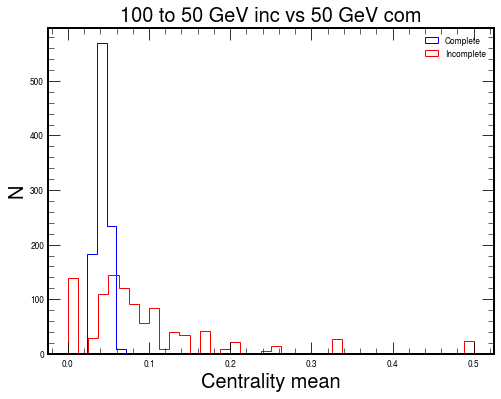

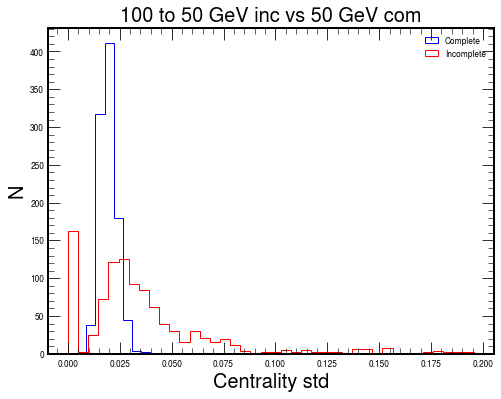

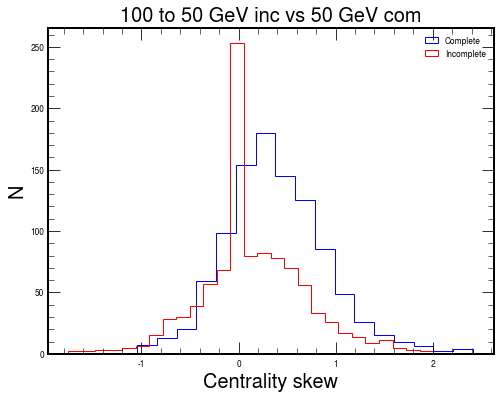

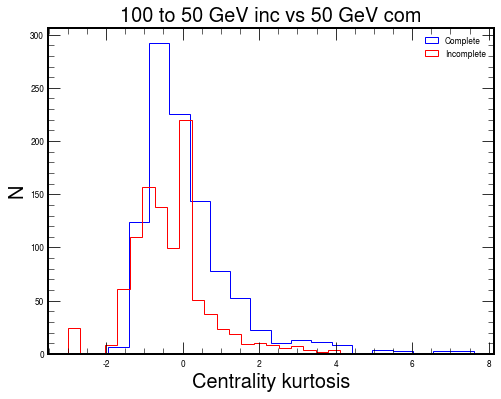

In [77]:
xlabels=["Centrality mean","Centrality std","Centrality skew","Centrality kurtosis"]
bins=[[40,40,20,20],[40,40,30,30]]
plotComVsIncCenParams(comCenParams,incCenParams,xlabels,bins=bins)

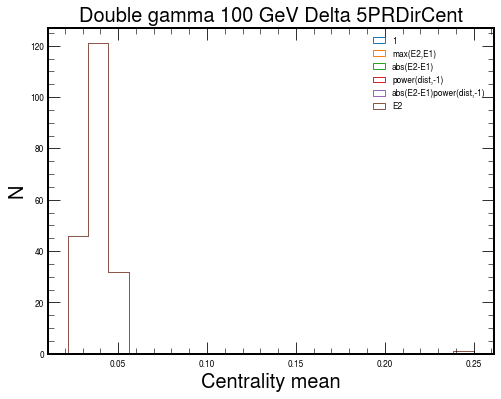

In [15]:
%matplotlib inline
centralityName="PRDirCent"
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(comCenParams[:,0,0], bins=20, histtype="step",label='1')
plt.hist(comCenParams[:,1,0], bins=20, histtype="step",label='max(E2,E1)')
plt.hist(comCenParams[:,2,0], bins=20, histtype="step",label='abs(E2-E1)')
plt.hist(comCenParams[:,3,0], bins=20, histtype="step",label='power(dist,-1)')
plt.hist(comCenParams[:,4,0], bins=20, histtype="step",label='abs(E2-E1)power(dist,-1)')
plt.hist(comCenParams[:,5,0], bins=20, histtype="step",label='E2')

plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Centrality mean",fontsize=20)
plt.title(datasetName+centralityName,fontsize=20)
plt.show()

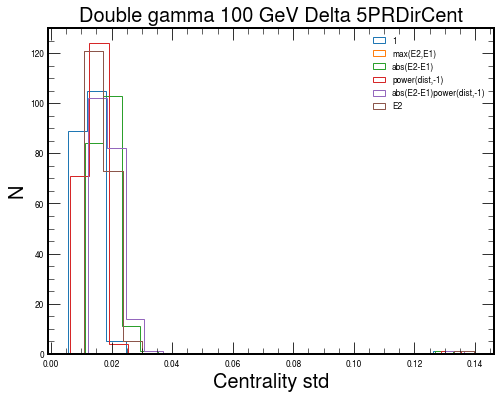

In [156]:
%matplotlib inline
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(comCenParams[:,0,1], bins=20, histtype="step",label='1')
plt.hist(comCenParams[:,1,1], bins=20, histtype="step",label='max(E2,E1)')
plt.hist(comCenParams[:,2,1], bins=20, histtype="step",label='abs(E2-E1)')
plt.hist(comCenParams[:,3,1], bins=20, histtype="step",label='power(dist,-1)')
plt.hist(comCenParams[:,4,1], bins=20, histtype="step",label='abs(E2-E1)power(dist,-1)')
plt.hist(comCenParams[:,5,1], bins=20, histtype="step",label='E2')

plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Centrality std",fontsize=20)
plt.title(datasetName+centralityName,fontsize=20)
plt.show()

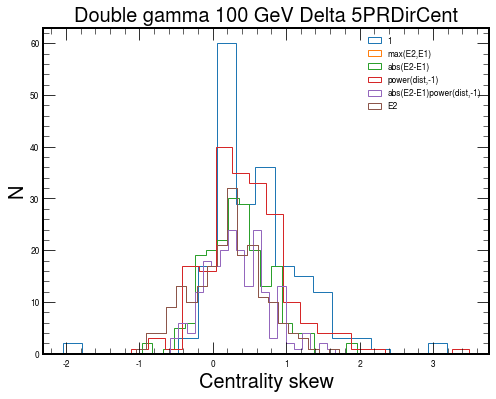

In [157]:
%matplotlib inline
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(comCenParams[:,0,2], bins=20, histtype="step",label='1')
plt.hist(comCenParams[:,1,2], bins=20, histtype="step",label='max(E2,E1)')
plt.hist(comCenParams[:,2,2], bins=20, histtype="step",label='abs(E2-E1)')
plt.hist(comCenParams[:,3,2], bins=20, histtype="step",label='power(dist,-1)')
plt.hist(comCenParams[:,4,2], bins=20, histtype="step",label='abs(E2-E1)power(dist,-1)')
plt.hist(comCenParams[:,5,2], bins=20, histtype="step",label='E2')

plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Centrality skew",fontsize=20)
plt.title(datasetName+centralityName,fontsize=20)
plt.show()

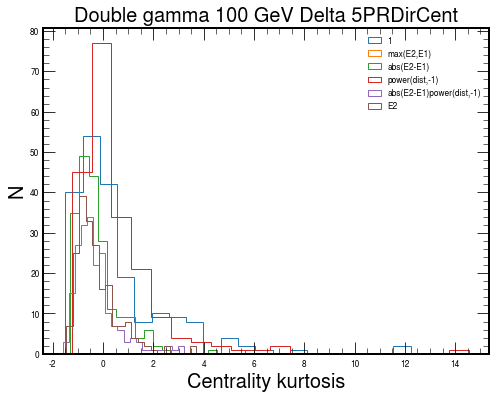

In [158]:
%matplotlib inline
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(comCenParams[:,0,3], bins=20, histtype="step",label='1')
plt.hist(comCenParams[:,1,3], bins=20, histtype="step",label='max(E2,E1)')
plt.hist(comCenParams[:,2,3], bins=20, histtype="step",label='abs(E2-E1)')
plt.hist(comCenParams[:,3,3], bins=20, histtype="step",label='power(dist,-1)')
plt.hist(comCenParams[:,4,3], bins=20, histtype="step",label='abs(E2-E1)power(dist,-1)')
plt.hist(comCenParams[:,5,3], bins=20, histtype="step",label='E2')

plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Centrality kurtosis",fontsize=20)
plt.title(datasetName+centralityName,fontsize=20)
plt.show()